In [48]:
from glob import glob
from tqdm import tqdm

import os 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import torch
import torchvision

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import SubsetRandomSampler, ConcatDataset
from torch.utils.data import random_split
from torchvision.io import read_image

from torchvision import transforms as t
from torchvision.transforms import functional as F

import PIL

torch.backends.cudnn.benchmark = True

In [2]:
!nvidia-smi

Sat Apr 13 10:54:18 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.86                 Driver Version: 551.86         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1080      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   46C    P8             13W /  200W |     827MiB /   8192MiB |     12%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
class SubsetTransforms(Dataset):
    def __init__(self, subset, transforms):
        self.subset = subset
        self.transforms = transforms
        
    def __getitem__(self, idx):
        x, y = self.subset[idx]
        return self.transforms(x), y

    def __len__(self):
        return len(self.subset)

In [4]:
def verify_image(fp):
    try:
        PIL.Image.open(fp).verify()
        return True
    except:
        return False

In [19]:
def random_split_ratio(dataset, test_size=.2, random_state=None):
    L = len(dataset)
    n_second = int(L*test_size)
    n_first = L - n_second
    if random_state:
        first_split, second_split = random_split(dataset, lengths=[n_first, n_second], generator=torch.Generator().manual_seed(random_state))
    else:
        first_split, second_split = random_split(dataset, lengths=[n_first, n_second])

    return first_split, second_split

In [20]:
def show(dataset, N=5, labels=None, figsize=(20, 20)):
    """ Shows random N samples from the dataset """
    idxs = np.random.randint(0, len(dataset)-1, N)

    fig, axs = plt.subplots(ncols=len(idxs), squeeze=False, figsize=figsize)

    for i, idx in enumerate(idxs):
        sample = dataset[idx]
        
        if isinstance(sample, tuple): # then it is in the form (x, y)
            sample, label = sample
            if isinstance(label, torch.TensorType):
                label = int(label.item())
            if labels:
                label = labels[label]
            axs[0, i].title.set_text(label)

        axs[0, i].imshow(torchvision.transforms.functional.to_pil_image(sample))
        axs[0, i].set(xticklabels = [], yticklabels = [], xticks = [], yticks = [])

    plt.show()

In [21]:
DATASET_PATH = 'C:/Users/Preinstall/Downloads/dataset'

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
transform = t.Compose([
    t.Resize((100, 100)),
    t.ToTensor(),
    t.ConvertImageDtype(torch.float32)
])

dataset = torchvision.datasets.ImageFolder(DATASET_PATH, is_valid_file=verify_image)
print(len(dataset))
training_dataset, test_dataset = random_split_ratio(dataset, random_state=42)
training_dataset, validation_dataset = random_split_ratio(training_dataset, random_state=42)

training_dataset = SubsetTransforms(training_dataset, transform)
print(len(training_dataset))
test_dataset = SubsetTransforms(test_dataset, transform)
print(len(test_dataset))
validation_dataset = SubsetTransforms(validation_dataset, transform)
print(len(validation_dataset))

30000
19200
6000
4800


In [44]:
def evaluate(dataset, model, device=device, **dataloader_args):
    dataloader = DataLoader(dataset, **dataloader_args)
    preds = []
    labels = []
    with torch.no_grad():
        model.eval()
        model.to(device)
        
        for x_batch, y_batch in tqdm(dataloader):
            x_batch = x_batch.to(device)
            y_batch = y_batch.tolist()
            
            outs = model(x_batch).detach()
            predictions = torch.argmax(torch.softmax(outs, 1), 1).tolist()
            
            preds.extend(predictions)
            labels.extend(y_batch)
            
    report = classification_report(labels, preds, digits = 3)
    report_dict = classification_report(labels, preds, output_dict=True)
    
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=['Keys','Wheels'],
            yticklabels=['Keys','Wheels'])
    plt.ylabel('Prediction',fontsize=13)
    plt.xlabel('Actual',fontsize=13)
    plt.title('Confusion Matrix',fontsize=17)
    plt.show()
    
    print(report)
    
    return report_dict


In [64]:
def train(model, loss_fn, train_loader, val_loader, return_model=False,
          device=device, lr_adjuster=None, epochs=10):
    
    n_train = len(train_loader.dataset)
    n_val = len(val_loader.dataset)
    
    training_losses = []
    validation_losses = []
    validation_accuracies = []  
    
    optimizer = get_optimizer(model)
    model.to(device)

    print("Number of samples")
    print("Training:", n_train)
    print('Validation:', n_val)
    for epoch in range(epochs):
        epoch_training_running_loss = 0
        epoch_val_running_loss = 0

        
        bar = tqdm(enumerate(train_loader), total=n_train//train_loader.batch_size)
        for batch_idx, (x_batch, y_batch) in bar:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            outs = model(x_batch)
            loss = loss_fn(outs, y_batch)
            loss.backward() 
            optimizer.step()
            optimizer.zero_grad()

            epoch_training_running_loss += (loss.item() * x_batch.size(0))

        with torch.no_grad():
            model.eval()
            vbar = tqdm(val_loader, total=n_val//val_loader.batch_size)
            val_predictions = []  
            val_targets = []  
            for x_batch, y_batch in vbar:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                
                outs = model(x_batch)
                loss = loss_fn(outs, y_batch)
                epoch_val_running_loss += (loss.item() * x_batch.size(0))
                
                
                val_predictions.extend(torch.argmax(outs, dim=1).cpu().numpy())
                val_targets.extend(y_batch.cpu().numpy())
                
            model.train()
        
        average_training_loss = epoch_training_running_loss / n_train
        average_validation_loss = epoch_val_running_loss / n_val

        training_losses.append(average_training_loss)
        validation_losses.append(average_validation_loss)
        
        
        validation_accuracy = accuracy_score(val_targets, val_predictions)
        validation_accuracies.append(validation_accuracy)
        lr=1e-4
        if lr_adjuster:
            print(f"epoch {epoch+1}/{epochs}, lr={lr} | avg. training loss: {average_training_loss:.3f}, avg. validation loss: {average_validation_loss:.3f}, validation accuracy: {validation_accuracy:.3f}")
        else:
            print(f"epoch {epoch+1}/{epochs} | avg. training loss: {average_training_loss:.3f}, avg. validation loss: {average_validation_loss:.3f}, validation accuracy: {validation_accuracy:.3f}")
            
    if return_model:
        return training_losses, validation_losses, model
    else:
        return training_losses, validation_losses

In [56]:
labels_to_idx = {"Wheel":1, "Key":0}
idx_to_labels = {0: "Key", 1: "Wheel"}

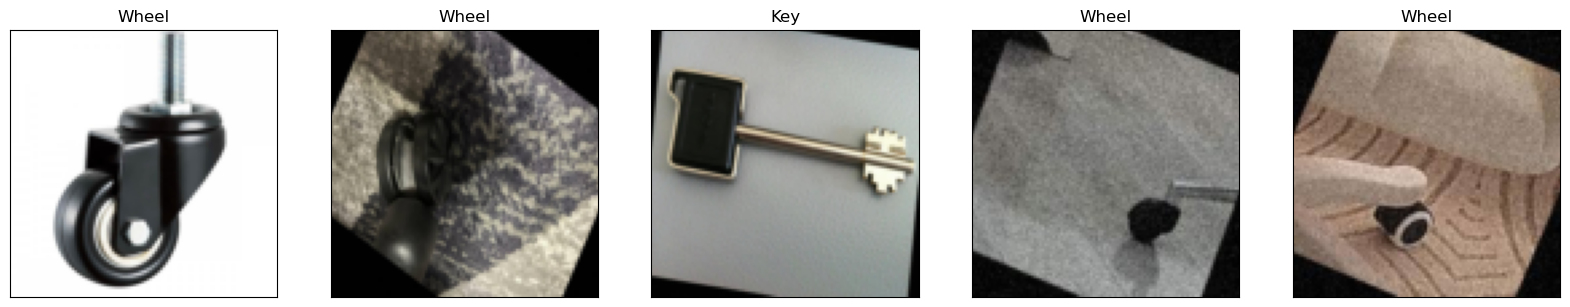

In [57]:
show(training_dataset, labels=idx_to_labels)

In [58]:
def get_optimizer(net):
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-8)
    return optimizer

def get_model():
    return Model()

In [59]:
torch.cuda.empty_cache()
import gc
del model
gc.collect()

18560

In [75]:
MAX_FILTERS = 256
IMAGE_HEIGHT = 100     
IMAGE_WIDTH = 100
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),           
            nn.BatchNorm2d(64),                       
            nn.ReLU(),                                
            nn.MaxPool2d(2))                          
        
        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),         
            nn.BatchNorm2d(int(MAX_FILTERS/2)),
            nn.ReLU(),
            nn.MaxPool2d(2))                          
        
        self.conv_layer_3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),        
            nn.BatchNorm2d(MAX_FILTERS),
            nn.ReLU(),
            nn.MaxPool2d(2))                          
        
        self.classifier = nn.Sequential(                    
            nn.Flatten(),                                     
            nn.Linear(in_features=MAX_FILTERS*int(IMAGE_WIDTH/8)*int(IMAGE_WIDTH/8), out_features=1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=1024, out_features=1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=1024, out_features=2),
            nn.Softmax(dim=1)
          )
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, x: torch.Tensor):                     
        x = self.conv_layer_1(x)
        x = self.dropout(x) 
        x = self.conv_layer_2(x)
        x = self.dropout(x)                   
        x = self.conv_layer_3(x)
        x = self.dropout(x) 
        x = self.classifier(x)
        return x

In [76]:
model = CNN()
#model = torch.load(r'C:\Users\Preinstall\Downloads\OriginalClassifier.pth')

In [78]:
def adjust_lr(optimizer, epoch):
    if epoch < 1:
        lr = 3e-5
    
    elif epoch < 5:
        lr = 1e-4
    
    elif epoch < 8:
        lr = 1e-5
    else:
        lr = 6e-6
        
    for p in optimizer.param_groups:
        p['lr'] = lr
    return lr
        
train_loader = DataLoader(training_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)


loss_fn = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

training_loss, validation_loss, model = train(model, loss_fn, train_loader, val_loader, 
                                              lr_adjuster=adjust_lr, return_model=True, device=device, epochs=20)

plt.title('Training performance')
plt.plot(training_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.legend()
plt.show()

Number of samples
Training: 19200
Validation: 4800


100%|██████████| 75/75 [08:15<00:00,  6.61s/it]
19it [01:03,  3.34s/it]                        


epoch 1/20, lr=0.0001 | avg. training loss: 0.382, avg. validation loss: 0.403, validation accuracy: 0.908


 31%|███       | 23/75 [02:39<06:00,  6.93s/it]


KeyboardInterrupt: 

In [42]:
print("total allocated memory on gpu (pytorch):", torch.cuda.memory.memory_allocated(device))

total allocated memory on gpu (pytorch): 173739008


In [43]:
print("Training report")
training_report = evaluate(training_dataset, model, device=device, batch_size=256)
print("Validation report")
validation_report = evaluate(validation_dataset, model, device=device, batch_size=256)

Training report


100%|██████████| 75/75 [04:20<00:00,  3.47s/it]


              precision    recall  f1-score   support

           0      0.984     0.952     0.968      9594
           1      0.954     0.984     0.969      9606

    accuracy                          0.968     19200
   macro avg      0.969     0.968     0.968     19200
weighted avg      0.969     0.968     0.968     19200

Validation report


100%|██████████| 19/19 [01:03<00:00,  3.32s/it]

              precision    recall  f1-score   support

           0      0.976     0.951     0.963      2383
           1      0.953     0.977     0.965      2417

    accuracy                          0.964      4800
   macro avg      0.965     0.964     0.964      4800
weighted avg      0.964     0.964     0.964      4800



Test report


100%|██████████| 24/24 [01:20<00:00,  3.37s/it]


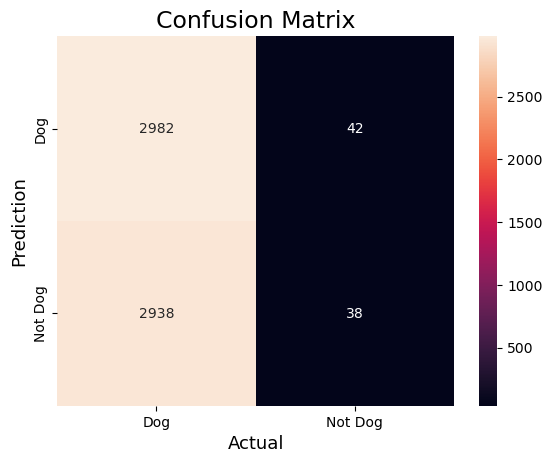

              precision    recall  f1-score   support

           0      0.504     0.986     0.667      3024
           1      0.475     0.013     0.025      2976

    accuracy                          0.503      6000
   macro avg      0.489     0.499     0.346      6000
weighted avg      0.489     0.503     0.348      6000



In [49]:
print("Test report")
test_report = evaluate(test_dataset, model, device=device, batch_size=256)

C:\Users\Preinstall\.conda\envs\ML\lib\site-packages\torch\nn\functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
C:\Users\Preinstall\.conda\envs\ML\lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


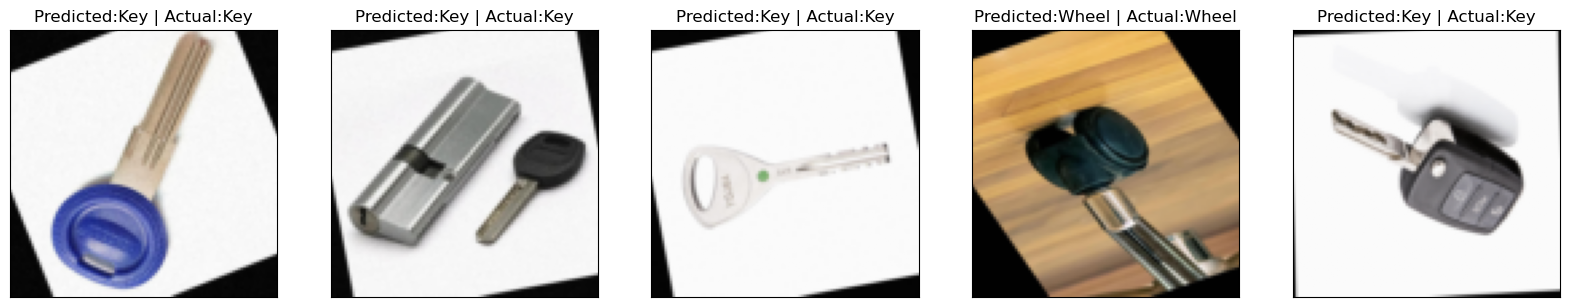

In [47]:
N=5
random_indices = np.random.randint(0, len(test_dataset)-1, N)
random_samples = [test_dataset[i] for i in random_indices]

fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(20,20))

for i in range(N):
    sample = random_samples[i]
    image, label = sample
    category = idx_to_labels[label]
    
    input_image = image.unsqueeze(0).to(device)
    model_output = model(input_image)
    prediction = torch.argmax(torch.softmax(model_output, -1)).item()
    predicted_category = idx_to_labels[prediction]
    
    axs[i].imshow(image.permute(1, 2, 0))
    axs[i].set(xticks=[], yticks=[], xticklabels=[], yticklabels=[])
    axs[i].set_title(f'Predicted:{predicted_category} | Actual:{category}')
plt.show()

In [46]:
torch.save(model, r'C:\Users\Preinstall\Downloads\OriginalClassifier.pth')

PicklingError: Can't pickle <class '__main__.CNN'>: it's not the same object as __main__.CNN

In [49]:
import pickle
with open('C:/Users/Preinstall/Downloads/a_model.pkl', 'wb') as f:
    pickle.dump(model, f)

PicklingError: Can't pickle <class '__main__.CNN'>: it's not the same object as __main__.CNN

In [51]:
import joblib

# Assuming `model` is your CNN model object
with open('C:/Users/Preinstall/Downloads/a_model.pkl', 'wb') as f:
    joblib.dump(model, f)

PicklingError: Can't pickle <class '__main__.CNN'>: it's not the same object as __main__.CNN

In [52]:
# Save model architecture as JSON
model_json = model.to_json()
with open("model_architecture.json", "w") as json_file:
    json_file.write(model_json)

# Save model weights
model.save_weights("model_weights.h5")


AttributeError: 'CNN' object has no attribute 'to_json'

In [53]:
torch.save(model.state_dict(), 'model_state_dict.pth')